--- Plotting graph 0 ---


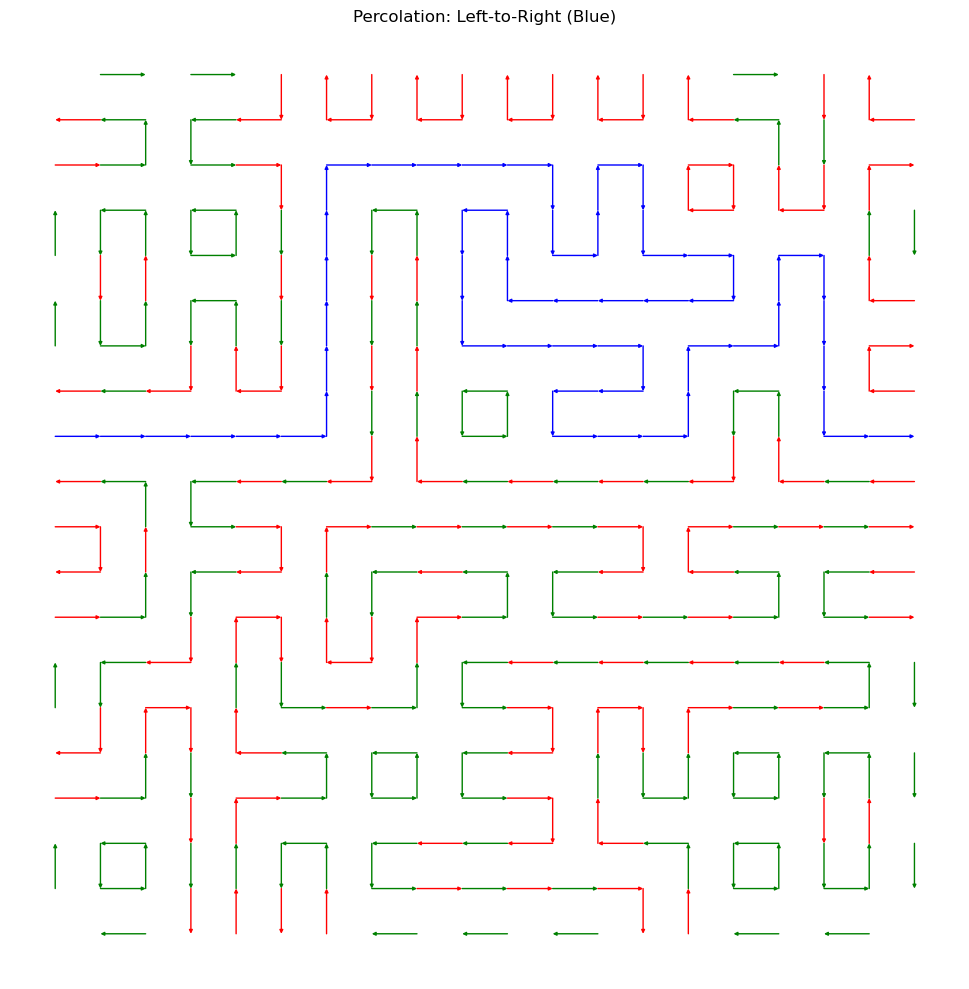


--- Simulation Complete ---
Node grid size: 20x20 (Checkerboard Plaquette Model, OBCs)
Trials: 100000
Probabilities: p(r)=0.500, p(t)=0.500
---
Percolation Probability (Top-to-Bottom):   0.09888
Percolation Probability (Bottom-to-Top):   0.0971
Percolation Probability (Left-to-Right):   0.09806
Percolation Probability (Right-to-Left):   0.09841


In [61]:
import collections
import random
import networkx as nx               # For graph objects and drawing
import matplotlib.pyplot as plt     # For plotting

def create_geometric_disorder_graph(M, p0, p1):
    disordered_graph = collections.defaultdict(list)
    edge_types = {}
    node_positions = {}

    #Create all M x M nodes
    for R in range(M):
        for C in range(M):
            node_positions[(R, C)] = (R, C)

    #Create edges
    for x in range(M-1):
        for y in range(M-1):

            # Only generate plaquettes in a checkerboard pattern
            if (y % 2) != (x % 2):

                choice = random.choices(['r', 't'], weights=[p0, p1], k=1)[0]
                bl = (x, y)
                br = (x+1, y)
                tl = (x, y+1)
                tr = (x+1 , y+1)

                if y % 2 == 0:
                    # --- "A" Plaquette (y is even) ---
                    if choice == 't':
                        disordered_graph[tl].append(tr)
                        edge_types[(tl, tr)] = 't'
                        disordered_graph[br].append(bl)
                        edge_types[(br, bl)] = 't'
                    else: # choice == 'r'
                        disordered_graph[tl].append(bl)
                        edge_types[(tl, bl)] = 'r'
                        disordered_graph[br].append(tr)
                        edge_types[(br, tr)] = 'r'
                else:
                    # --- "B" Plaquette (y is odd) ---
                    if choice == 't':
                        disordered_graph[bl].append(tl)
                        edge_types[(bl, tl)] = 't'
                        disordered_graph[tr].append(br)
                        edge_types[(tr, br)] = 't'
                    else: # choice == 'r'
                        disordered_graph[tr].append(tl)
                        edge_types[(tr, tl)] = 'r'
                        disordered_graph[bl].append(br)
                        edge_types[(bl, br)] = 'r'

    return disordered_graph, edge_types, node_positions, M

class UnionFind:
    def __init__(self):
        self.id_array = [0]
    def new_label(self):
        label = len(self.id_array)
        self.id_array.append(label)
        return label
    def find_root(self, i):
        if self.id_array[i] == i:
            return i
        self.id_array[i] = self.find_root(self.id_array[i])
        return self.id_array[i]
    def union(self, i, j):
        root_i = self.find_root(i)
        root_j = self.find_root(j)
        if root_i != root_j:
            self.id_array[root_i] = root_j


def check_percolation(graph, all_nodes, start_nodes, end_nodes):
    labels = {}
    for node in all_nodes:
        labels[node] = 0

    clusters = UnionFind()
    start_roots = set()

    for node in start_nodes:
        if node in labels and labels[node] == 0:
            current_label = clusters.new_label()
            start_roots.add(current_label)
            labels[node] = current_label
            queue = collections.deque([node])

            while queue:
                current_node = queue.popleft()
                for neighbor in graph.get(current_node, []):
                    if neighbor in labels:
                        neighbor_label = labels[neighbor]
                        if neighbor_label == 0:
                            labels[neighbor] = current_label
                            queue.append(neighbor)
                        else:
                            clusters.union(current_label, neighbor_label)

    spanning_roots = set()
    for node in end_nodes:
        if node in labels and labels[node] > 0:
            root = clusters.find_root(labels[node])
            if root in start_roots:
                spanning_roots.add(root)

    if not spanning_roots:
        return False, set()

    spanning_nodes = set()
    for node in all_nodes:
        if node in labels and labels[node] > 0 and clusters.find_root(labels[node]) in spanning_roots:
            spanning_nodes.add(node)

    spanning_edges = set()
    for u_node in spanning_nodes:
        for v_node in graph.get(u_node, []):
            if v_node in spanning_nodes:
                spanning_edges.add((u_node, v_node))

    return True, spanning_edges


def plot_graph(M, graph_dict, node_pos, edge_types, spanning_edges, ax):
    G = nx.DiGraph()
    G.add_nodes_from(node_pos.keys())

    all_edges = []
    for u, neighbors in graph_dict.items():
        for v in neighbors:
            all_edges.append((u, v))
    G.add_edges_from(all_edges)

    color_map = {'r': 'red', 't': 'green'}
    final_edge_colors = []

    for u, v in G.edges():
        if (u, v) in spanning_edges:
            final_edge_colors.append('blue')
        else:
            edge_type = edge_types.get((u, v))
            final_edge_colors.append(color_map.get(edge_type, 'gray'))

    nx.draw(
        G,
        pos=node_pos,
        ax=ax,
        node_size=0,
        node_color='black',
        edge_color=final_edge_colors,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=5
    )
    ax.set_aspect('equal') # Keep aspect ratio square
    ax.set_xlim(-1, M)
    ax.set_ylim(-1, M)



def run_simulation(M, p0, p1, num_trials=1000, plot_nth_graph=None):
    # Define boundary lists for the M x M grid
    top_row    = [(c, M - 1) for c in range(M)]
    bottom_row = [(c, 0) for c in range(M)]
    left_side  = [(0, r) for r in range(M)]
    right_side = [(M - 1, r) for r in range(M)]

    # Counters for all 4 directions
    perc_count_v_tb = 0 # Top-to-Bottom
    perc_count_h_lr = 0 # Left-to-Right
    perc_count_v_bt = 0 # Bottom-to-Top
    perc_count_h_rl = 0 # Right-to-Left

    for i in range(num_trials):
        graph, edge_types, node_pos, M = \
            create_geometric_disorder_graph(M, p0, p1)

        all_nodes = node_pos.keys()

        # --- Check all 4 directions ---
        found_v_tb, spanning_edges_v_tb = check_percolation(
             graph, all_nodes, top_row, bottom_row)
        if found_v_tb:
            perc_count_v_tb += 1

        found_h_lr, spanning_edges_h_lr = check_percolation(
             graph, all_nodes, left_side, right_side)
        if found_h_lr:
            perc_count_h_lr += 1

        found_v_bt, spanning_edges_v_bt = check_percolation(
             graph, all_nodes, bottom_row, top_row)
        if found_v_bt:
            perc_count_v_bt += 1

        found_h_rl, spanning_edges_h_rl = check_percolation(
             graph, all_nodes, right_side, left_side)
        if found_h_rl:
            perc_count_h_rl += 1

        # --- PLOTTING LOGIC (MODIFIED) ---
        if i == plot_nth_graph:
            print(f"--- Plotting graph {i} ---")
            # Create a SINGLE figure and axis
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            # Find the first path to plot (if any)
            spanning_edges_to_plot = set()
            plot_title = "No Spanning Path Found"

            if found_v_tb:
                spanning_edges_to_plot = spanning_edges_v_tb
                plot_title = "Percolation: Top-to-Bottom (Blue)"
            elif found_h_lr:
                spanning_edges_to_plot = spanning_edges_h_lr
                plot_title = "Percolation: Left-to-Right (Blue)"
            elif found_v_bt:
                spanning_edges_to_plot = spanning_edges_v_bt
                plot_title = "Percolation: Bottom-to-Top (Blue)"
            elif found_h_rl:
                spanning_edges_to_plot = spanning_edges_h_rl
                plot_title = "Percolation: Right-to-Left (Blue)"


            plot_graph(M, graph, node_pos, edge_types, spanning_edges_to_plot, ax)
            ax.set_title(plot_title)
            plt.tight_layout()
            plt.show()

    # Calculate all 4 probabilities
    P_v_tb = perc_count_v_tb / num_trials
    P_h_lr = perc_count_h_lr / num_trials
    P_v_bt = perc_count_v_bt / num_trials
    P_h_rl = perc_count_h_rl / num_trials

    return P_v_tb, P_h_lr, P_v_bt, P_h_rl

####main code
M_size = 20 # This is now the node grid size
num_runs = 100000
plot_this_graph = 0 # Plot the very first graph

p0_val = 0.5  # p(r)
p1_val = 0.5  # p(t)


prob_v_tb, prob_h_lr, prob_v_bt, prob_h_rl = run_simulation(
    M_size,
    p0_val,
    p1_val,
    num_trials=num_runs,
    plot_nth_graph=plot_this_graph
)

# Print final results (MODIFIED)
print(f"Node grid size: {M_size}x{M_size} (Checkerboard Plaquette Model, OBCs)")
print(f"Trials: {num_runs}")
print(f"Probabilities: p(r)={p0_val:.3f}, p(t)={p1_val:.3f}")
print(f"Percolation Probability (Top-to-Bottom):   {prob_v_tb}")
print(f"Percolation Probability (Bottom-to-Top):   {prob_v_bt}")
print(f"Percolation Probability (Left-to-Right):   {prob_h_lr}")
print(f"Percolation Probability (Right-to-Left):   {prob_h_rl}")